In [1]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#from brutus import pdf
#import brutus

import dynesty
from dynesty import plotting as dyplot

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cmplt
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap

import seaborn as sns

from PIL import Image

from yt.config import ytcfg
import yt
from yt.analysis_modules.ppv_cube.api import PPVCube
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler

import skimage
from skimage import filters

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian

from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee

#I/O
import h5py
import pickle
import glob
import copy
import time
import os
from bs4 import BeautifulSoup
import scipy.io as sio

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = True
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

/Users/aksaydjari/miniconda3/envs/RWST/lib/python3.6/site-packages/ipykernel_launcher.py:33: VisibleDeprecationWarning: Development of the PPVCube module has been moved to the yt_astro_analysis package. This version is deprecated and will be removed from yt in a future release. See https://github.com/yt-project/yt_astro_analysis for further information.


In [69]:
import aotools
from aotools.turbulence import infinitephasescreen
import imageio

In [8]:
from pytransit import QuadraticModel
tm = QuadraticModel()

In [130]:
times = np.linspace(-0.3,0.3,101)
tm.set_data(times)

In [237]:
transit_curve = tm.evaluate(k=0.1, ldc=[0.2, 0.1], t0=0.0, p=1.0, a=1.3, i=0.5*np.pi)

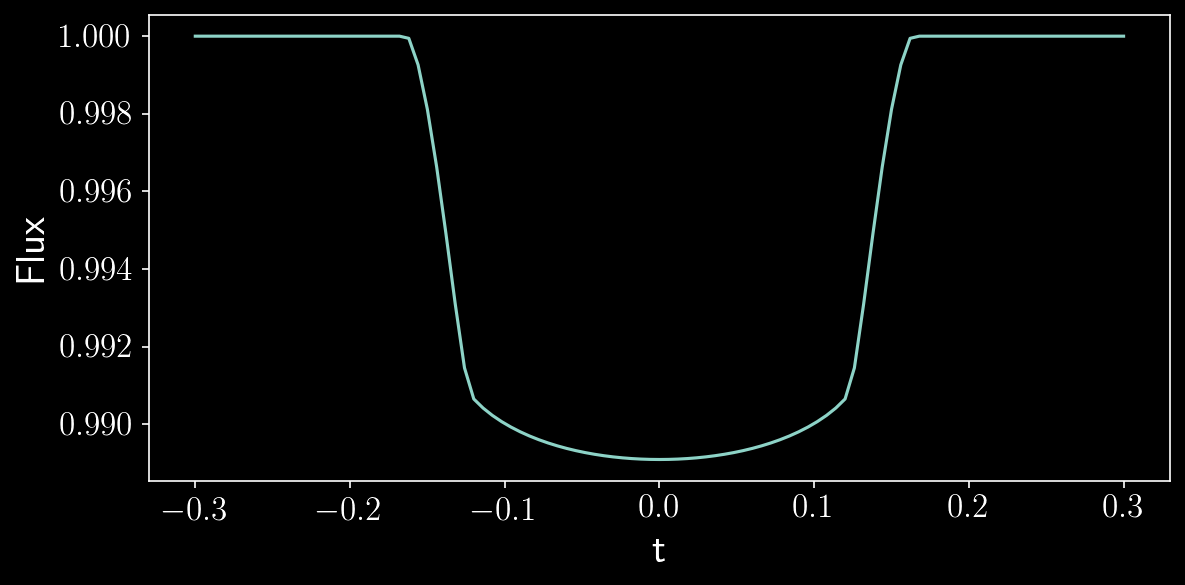

In [238]:
#Figure
fig = plt.figure(figsize=(8,4), dpi=150)
ax = fig.add_subplot(111)
plt.plot(times,transit_curve)
plt.xlabel('t')
plt.ylabel('Flux')
fig.tight_layout()

Now, we implement a series of images with this net flux from the star. Each series gets a subseries of images where we have convolved by a turbulent psf. Try to add gaussian and poisson noise to each image.

In [258]:
def star_flux(flux,sigma_x = 1.,sigma_y = 2.,size = 256):
    x = np.linspace(-size/2, size/2-1, size)
    y = np.linspace(-size/2, size/2-1, size)
    x, y = np.meshgrid(x, y)
    
    z = (flux-.96)/.04*(1/(2*np.pi*sigma_x*sigma_y) * np.exp(-(x**2/(2*sigma_x**2)
         + y**2/(2*sigma_y**2))))
    return z

In [241]:
im_series = []
for i in transit_curve:
    im_series.append(star_flux(i))

In [243]:
def convolver(turb,im2):
    if1 = turb
    if2 = np.fft.fftshift(np.fft.fft2(im2))
    conv = np.multiply(if1,if2)
    iif = np.fft.ifft2(conv)
    return iif

z = star_flux(transit_curve[50])
i=1
scrn = infinitephasescreen.PhaseScreenKolmogorov(256, 0.4/256, 0.05, 0.5, random_seed=107*i)
temp = convolver(scrn.scrn,z)
out = np.abs(temp)
#out = out.astype(np.uint8)

In [244]:
out.max()

0.06992638749877741

In [175]:
imageio.imwrite('data/transit_test_{}.png'.format(i), out)

In [176]:
out

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [177]:
np.random.normal(0, 0.2, (256,256))

array([[-0.10477741, -0.05005092, -0.09795811, ...,  0.19305434,
        -0.3811512 ,  0.31436905],
       [-0.1628196 , -0.09367171, -0.20562008, ..., -0.04392223,
        -0.1132318 ,  0.14795855],
       [ 0.1926074 ,  0.05278626, -0.09550701, ..., -0.23016119,
         0.01773249,  0.11736137],
       ...,
       [-0.13677393,  0.27046831, -0.09322259, ..., -0.46114608,
         0.05563266, -0.09398013],
       [-0.00854502, -0.11175048,  0.19031207, ...,  0.01303815,
        -0.29128406, -0.05043029],
       [ 0.05613399,  0.08748885,  0.10220518, ...,  0.01935429,
        -0.03418512, -0.00784004]])

In [181]:
np.random.poisson(out).shape

(256, 256)

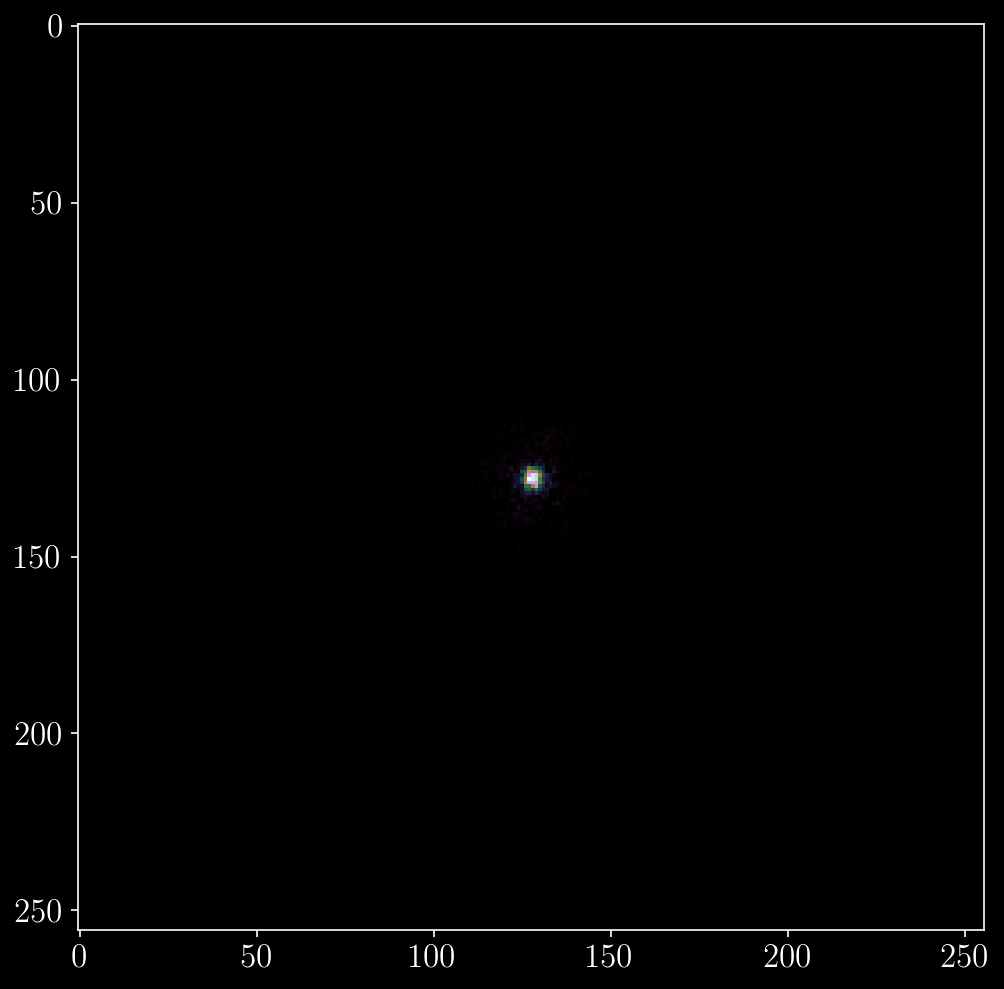

In [184]:
fig = plt.figure(figsize=(8,8), dpi=150)
index = 29
ax = fig.add_subplot(1,1,1)
ax.imshow(
    np.random.poisson(out),
    #norm=SymLogNorm(.1),
#     vmin=-0.9705787,
#     vmax=0.9705787,
    origin='upper',
    interpolation='nearest',
    cmap='cubehelix',
    aspect='equal'
)

In [218]:
def noise(img,gauss_sig=5):
    #convert from 0-1 norm to unit16
    in_img = 32767*img
    out_img = np.random.poisson(in_img)
    out_img += np.random.normal(0, gauss_sig, (img.shape[0],img.shape[0])).astype(np.int64)
    return np.abs(out_img)

In [219]:
#example on one image
i = 50
j = 12
z = star_flux(transit_curve[i])
scrn = infinitephasescreen.PhaseScreenKolmogorov(256, 0.4/256, 0.05, 0.5, random_seed=107*j)
temp = convolver(scrn.scrn,z)
out = np.abs(temp)

final_img = noise(out)

In [220]:
type(final_img[0][0])

numpy.int64

In [221]:
imageio.imwrite('data/transit_test_{}.png'.format(i), final_img.astype(np.uint8))

In [265]:
series_transit = []
#single subseries
for indx, i in enumerate(transit_curve):
    z = star_flux(i)
    scrn = infinitephasescreen.PhaseScreenKolmogorov(256, 0.4/256, 0.05, 0.5, random_seed=107*indx)
    temp = convolver(scrn.scrn,z)
    out = np.abs(temp)
    final_img = noise(out)
    series_transit.append(final_img)

In [266]:
temp = [np.sum(i) for i in series_transit]

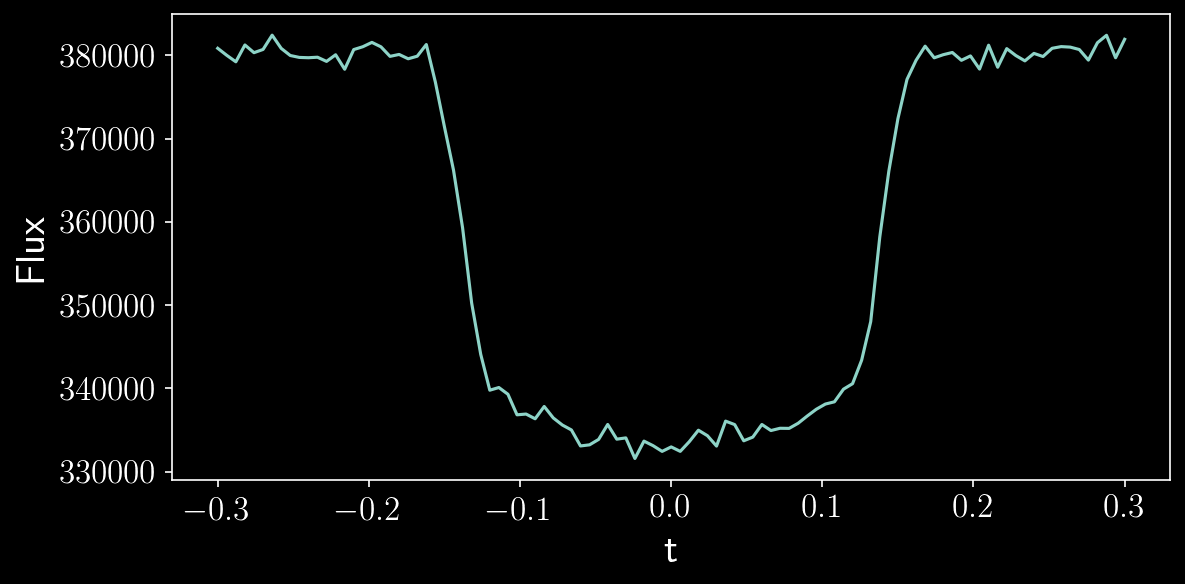

In [267]:
#Figure
fig = plt.figure(figsize=(8,4), dpi=150)
ax = fig.add_subplot(111)
plt.plot(times,temp)
plt.xlabel('t')
plt.ylabel('Flux')
fig.tight_layout()

In [272]:
z = z*32767

In [274]:
z.astype(np.uint8).max()

253